<h1>2-D Poisson Equation Solver</h1>
            

In [1]:
import numpy as np
from scipy import integrate,constants,misc,interpolate
import pylab as pl
import matplotlib.pyplot as plt
from scipy.optimize import root,newton_krylov
from numpy import zeros_like, mgrid, zeros
from scipy.special import erf
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from scipy.integrate import quad



%matplotlib inline



pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

<h2> Input Boundary Conditions for $\phi(x,y)$ in this cell </h2>

In [2]:
#Defining parameters

nx                  = 100                  #Number of grid points
hx                  = 1.0/(nx-1)           #Step size of calculation

ny                  = 100
hy                  = 1.0/(ny-1)

phi_down, phi_up    = 0, 0                 #Boundary conditions
phi_left, phi_right = 0, 0

epsilon             = 0                    # small quantity
x                   = np.linspace(epsilon,1.0, nx)
y                   = np.linspace(epsilon,1.0, ny)

<h1>Solving :</h1>

<h1>$\mathrm{-\vec{\nabla}^{2}\phi(x,y)\;=\;\rho(x,y)}$</h1>

In [3]:
def residual(phi_2D):
    ### np.lib.pad adds a padding/boundary of specified values around the given matrix
    phi_2D_with_boundary = np.lib.pad(phi_2D,((1,1),(1,1)),'constant',constant_values=((phi_left,phi_right),(phi_down,phi_up)))

    ### Calculating finite difference 
    finite_difference_x  = [np.convolve(row,[1,-2,1]) for row in phi_2D_with_boundary]     #Taking convolution
    finite_difference_x  = np.array(finite_difference_x)                                   #Considering values only in desirable region
    d2_phi_by_d2_x       = finite_difference_x[1:-1,2:-2]/(hx**2)

    finite_difference_y  = [np.convolve(column,[1,-2,1]) for column in phi_2D_with_boundary.T]    #Taking convolution
    finite_difference_y  = np.array(finite_difference_y)                                   #Considering values only in desirable region
    finite_difference_y  = finite_difference_y.T
    d2_phi_by_d2_y       = finite_difference_y[2:-2,1:-1]/(hy**2)

    return d2_phi_by_d2_x + d2_phi_by_d2_y + rho


<h3>Backend functions for defining $\rho$</h3>

In [4]:
def gaussian_2D( x, y, sigma_x, sigma_y, mean_x, mean_y):
    constant =  1/(2*np.pi*sigma_x*sigma_y)
    return constant * np.exp(-((x-mean_x)**2/(2*sigma_x**2) + (y-mean_y)**2/(2*sigma_y**2)))

def sin_function(x,y):
    return np.sin(2*np.pi*2*x)

#Some test functions
def drum_head_2D( x, y):
    return (x-x**2)*(y-y**2)

def sum_2D( x, y):
    return x+y

def product_2D( x, y):
    return x*y

In [5]:
def gaussian_rho( x, y, sigma_x, sigma_y, mean_x, mean_y):
    Rho         = np.zeros((nx,ny))
    for m in range(len(x)):
        for n in range(len(y)):
            Rho[m][n] = gaussian_2D( x[m], y[n], sigma_x, sigma_y, mean_x, mean_y)
    return Rho
### RHO OF TEST FUNCTIONS

def drum_head_rho( x, y):
    Rho         = np.zeros((nx,ny))
    for m in range(len(x)):
        for n in range(len(x)):
            Rho[m][n] = drum_head_2D( x[m], y[n])
    return Rho

def sin_rho( x, y):
    Rho         = np.zeros((nx,ny))
    for m in range(len(x)):
        for n in range(len(x)):
            Rho[m][n] = sin_function( x[m], y[n])
    return Rho

def sum_rho(x, y):
    Rho         = np.zeros((nx,ny))
    for i in range(len(x)):
        for j in range(len(x)):
            Rho[i][j] = sum_2D( x[i], y[j])
    return Rho

def product_rho(x, y):
    Rho         = np.zeros((nx,ny))
    for i in range(len(x)):
        for j in range(len(x)):
            Rho[i][j] = product_2D( x[i], y[j])
    return Rho

In [6]:
#Taking a test case of the current density function

current                = 1    # I
radius_of_wire         = 1    # radius_{wire}
total_number_of_turns  = 1    # N
coil_width             = .10    # coil_width
coil_height            = .20    # coil_height
epsilon_f                = 1./100 # regulator
inner_radius           = .5

r_start = 1e-5
r_end   = 20.
z_start = -20
z_end   = 20

def fitted_function (x, y):
    f = 0.25*(np.tanh(1./epsilon_f * (x-0.4)) -              \
              np.tanh(1./epsilon_f * (x -0.6)))              \
            *(np.tanh(1./epsilon_f * (y- 0.4))               \
            - np.tanh(1./epsilon_f * (y - 0.6)))
    return f

def current_density_function (x,y):
    Rho         = np.zeros((nx,ny))
    for i in range(len(x)):
        for j in range(len(x)):
            Rho[i][j] = fitted_function( x[i], y[j])
    return Rho



In [7]:
### FUNCTION FOR PLOTTING SOLUTIONS

def plot_in_3d_2d(function,title_3d,title_2d,z_axis):
    #### VISUALIZE IN 3D
    fig = pl.figure(figsize=(12,7))

    ax = fig.gca(projection='3d')
    x, y = mgrid[0:1:(nx*1j), 0:1:(ny*1j)]
    X, Y, Z = x,y,function

    ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
    cset = ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
    cset = ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
    cset = ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

    ax.set_xlabel('$\mathrm{X}$')
    ax.set_ylabel('$\mathrm{Y}$')
    ax.set_zlabel(z_axis)

    ax.set_title(title_3d)

    plt.show()
    #### VISUALIZE IN 2D
    fig = pl.figure(figsize=(17,5))

    plt.subplot(1, 2, 2)
    x, y = mgrid[0:1:(nx*1j), 0:1:(ny*1j)]
    plt.title(title_2d)
    plt.xlabel('$\mathrm{X}$')
    plt.ylabel('$\mathrm{Y}$')
    plt.contourf(x,y, function, 100)
    plt.colorbar()
    plt.show()



<h2>Test functions for $\rho$</h2>
<ul>
<li>Gaussian: 
<br/>
$\rho\; = \; \frac{1}{2\pi\sigma_{x}\sigma_{y}} \times e^{-\frac{(x-\mu_{x})^2}{2 \sigma_{x}^{2}}} \times e^{-\frac{(y-\mu_{y})^2}{2 \sigma_{y}^{2}}} $
</li>



<li>Summation
<br/>
$\rho = x + y $
</li>


<li> Product
<br/>
$\rho = x \cdot y $
</li>
</ul>

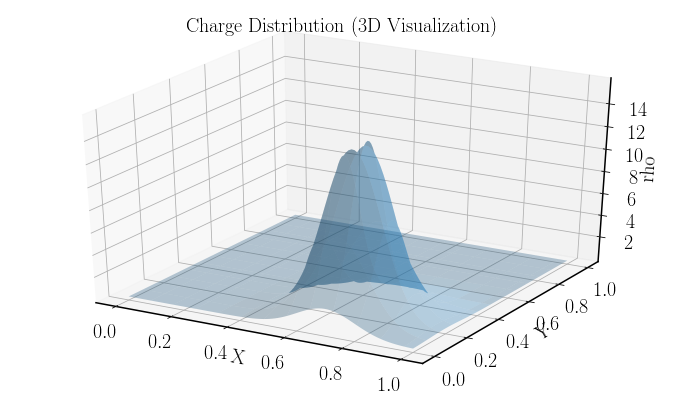

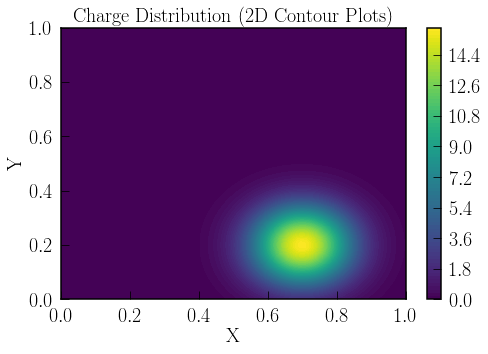

In [8]:
### DEFINING RHO
sigma_x         = 0.1
sigma_y         = 0.1
mean_x          = 0.7
mean_y          = 0.2


epsilon             = 0              #A small quantity
x                   = np.linspace(epsilon,1.0,nx) 
y                   = np.linspace(epsilon,1.0,ny) 

rho              = gaussian_rho( x, y, sigma_x, sigma_y, mean_x, mean_y)
#rho               = sin_rho( x, y)
#rho              = drum_head_rho(x,y)
#rho              = sum_rho( x, y)
#rho              = product_rho( x, y)
#rho                = current_density_function(x, y)
#rho                = current_density_function(x, y) + current_density_function(x, y-0.5)

plot_in_3d_2d(rho,'$\mathrm{Charge\;Distribution\;(3D\;Visualization)}$','$\mathrm{Charge\;Distribution\;(2D\;Contour\;Plots)}$','$\mathrm{rho}$')

Residual: 8.52029e-07


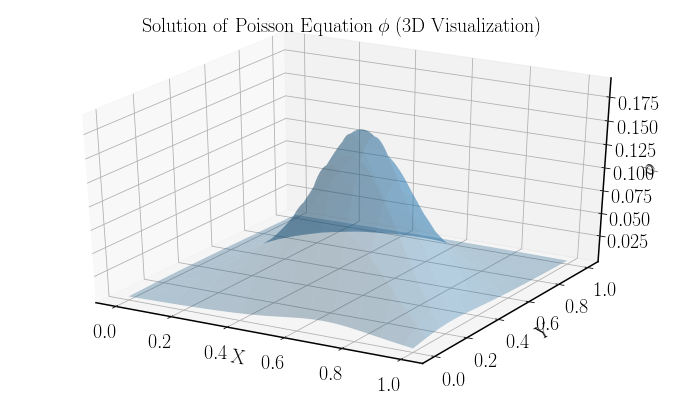

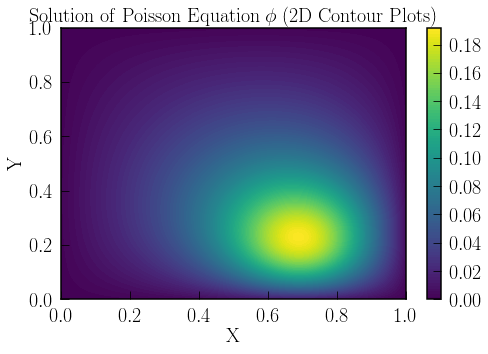

In [9]:
# solving
guess = zeros((nx, ny), float)
sol = root(residual, guess, method='krylov', options={'disp': False})
print('Residual: %g' % abs(residual(sol.x)).max())


phi  =sol.x

###  PLOTTING PHI
plot_in_3d_2d(phi,'$\mathrm{Solution\;of\;Poisson\;Equation\;\phi\;(3D\;Visualization)}$','$\mathrm{Solution\;of\;Poisson\;Equation\;\phi\;(2D\;Contour\;Plots)}$','$\mathrm{\phi}$')

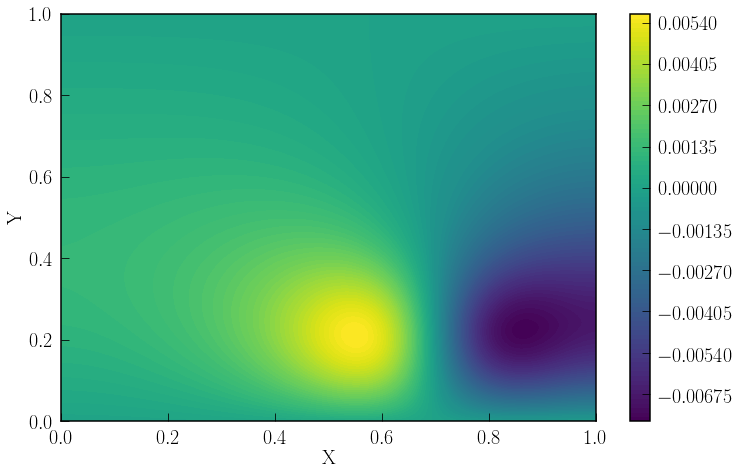

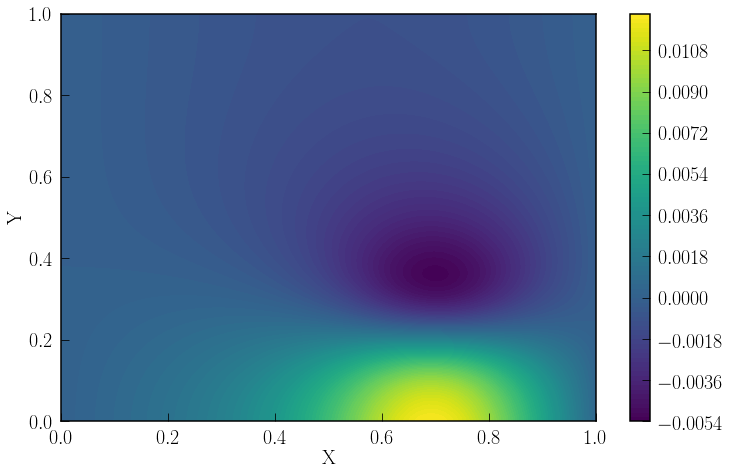

In [10]:
### Calculating Electric field

vgrad = np.gradient(phi)
xgrad = vgrad[0]
ygrad = vgrad[1]

E_mag = np.power(xgrad, 2) + np.power(ygrad, 2)

x, y = mgrid[0:1:(nx*1j), 0:1:(ny*1j)]
plt.xlabel('$\mathrm{X}$')
plt.ylabel('$\mathrm{Y}$')
plt.contourf(x,y, xgrad, 100)
plt.colorbar()
plt.show()

plt.xlabel('$\mathrm{X}$')
plt.ylabel('$\mathrm{Y}$')
plt.contourf(x,y, ygrad, 100)
plt.colorbar()
plt.show()

<h1>Finding Series Expansion of $\rho(x,y)$</h1>

<h6>$\rho(x,y) = \sum_{i,j} a_{i,j} cos(2\pi k_{i} x) cos(2\pi k_{j} y) +$ 

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\sum_{i,j} b_{i,j} cos(2\pi k_{i} x) sin(2\pi k_{j} y) +$ 

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\sum_{i,j} c_{i,j} sin(2\pi k_{i} x) cos(2\pi k_{j} y) +$

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\sum_{i,j} d_{i,j} sin(2\pi k_{i} x) sin(2\pi k_{j} y) $</h6>

<h6>where <ul>

<li>
$a_{i,j} = \kappa \int_{0}^{1} \int_{0}^{1} \rho(x,y)cos(2\pi k_{i} x)\;cos(2\pi k_{j} y) dx dy$
</li>

<li>
$b_{i,j} = \kappa \int_{0}^{1} \int_{0}^{1} \rho(x,y)cos(2\pi k_{i} x)\;sin(2\pi k_{j} y) dx dy$
</li>

<li>
$c_{i,j} = \kappa \int_{0}^{1} \int_{0}^{1} \rho(x,y)sin(2\pi k_{i} x)\;cos(2\pi k_{j} y) dx dy$
</li>

<li>
$d_{i,j} = \kappa \int_{0}^{1} \int_{0}^{1} \rho(x,y)sin(2\pi k_{i} x)\;sin(2\pi k_{j} y) dx dy$
</li>
</ul>
</h6>

\begin{align}
\text{Where } \kappa & = 1 \text{ if } i = 0 \text{ and } j = 0 \\
& = 2 \text{ if } i = 0 \text{ or } j > 0\\
& = 2 \text{ if } i > 0 \text{ or } j = 0\\
& = 4 \text{ if } i> 0 \text{ and } j > 0
\end{align}



In [11]:
#Defining functions to calculate coefficients of rho


# def integrand_for_a_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
#     return fitted_function( x, y)*np.cos(2*np.pi*i*x)*np.cos(2*np.pi*j*y)

# def integrand_for_b_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
#     return fitted_function( x, y)*np.cos(2*np.pi*i*x)*np.sin(2*np.pi*j*y)

# def integrand_for_c_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
#     return fitted_function( x, y)*np.sin(2*np.pi*i*x)*np.cos(2*np.pi*j*y)

# def integrand_for_d_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
#     return fitted_function( x, y)*np.sin(2*np.pi*i*x)*np.sin(2*np.pi*j*y)

#############################################################################################################

# def integrand_for_a_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
#     return gaussian_2D( x, y, sigma_x, sigma_y, mean_x, mean_y)*np.cos(2*np.pi*i*x)*np.cos(2*np.pi*j*y)

# def integrand_for_b_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
#     return gaussian_2D( x, y, sigma_x, sigma_y, mean_x, mean_y)*np.cos(2*np.pi*i*x)*np.sin(2*np.pi*j*y)

# def integrand_for_c_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
#     return gaussian_2D( x, y, sigma_x, sigma_y, mean_x, mean_y)*np.sin(2*np.pi*i*x)*np.cos(2*np.pi*j*y)

# def integrand_for_d_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
#     return gaussian_2D( x, y, sigma_x, sigma_y, mean_x, mean_y)*np.sin(2*np.pi*i*x)*np.sin(2*np.pi*j*y)

#############################################################################################################


def integrand_for_a_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
    return sin_function( x, y)*np.cos(2*np.pi*i*x)*np.cos(2*np.pi*j*y)

def integrand_for_b_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
    return sin_function( x, y)*np.cos(2*np.pi*i*x)*np.sin(2*np.pi*j*y)

def integrand_for_c_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
    return sin_function( x, y)*np.sin(2*np.pi*i*x)*np.cos(2*np.pi*j*y)

def integrand_for_d_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
    return sin_function( x, y)*np.sin(2*np.pi*i*x)*np.sin(2*np.pi*j*y)

#############################################################################################################

# def integrand_for_a_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
#     return drum_head_2D( x, y)*np.cos(2*np.pi*i*x)*np.cos(2*np.pi*j*y)

# def integrand_for_b_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
#     return drum_head_2D( x, y)*np.cos(2*np.pi*i*x)*np.sin(2*np.pi*j*y)

# def integrand_for_c_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
#     return drum_head_2D( x, y)*np.sin(2*np.pi*i*x)*np.cos(2*np.pi*j*y)

# def integrand_for_d_ij(x, y, sigma_x, sigma_y, mean_x, mean_y , i , j):
#     return drum_head_2D( x, y)*np.sin(2*np.pi*i*x)*np.sin(2*np.pi*j*y)

#############################################################################################################

def integral_for_a_ij(sigma_x, sigma_y, mean_x, mean_y , i , j):
    value , error = integrate.nquad(integrand_for_a_ij,[[0,1],[0,1]], args = (sigma_x, sigma_y, mean_x, mean_y , i , j))
    return value

def integral_for_b_ij(sigma_x, sigma_y, mean_x, mean_y , i , j):
    value , error = integrate.nquad(integrand_for_b_ij,[[0,1],[0,1]], args = (sigma_x, sigma_y, mean_x, mean_y , i , j))
    return value

def integral_for_c_ij(sigma_x, sigma_y, mean_x, mean_y , i , j):
    value , error = integrate.nquad(integrand_for_c_ij,[[0,1],[0,1]], args = (sigma_x, sigma_y, mean_x, mean_y , i , j))
    return value

def integral_for_d_ij(sigma_x, sigma_y, mean_x, mean_y , i , j):
    value , error = integrate.nquad(integrand_for_d_ij,[[0,1],[0,1]], args = (sigma_x, sigma_y, mean_x, mean_y , i , j))
    return value

############################################################################################################################



In [14]:
#Computing the coefficients of rho

epsilon             = 0.00
x                   = np.linspace(epsilon, 1.0, nx) 
y                   = np.linspace(epsilon, 1.0, ny) 

#rho                 = gaussian_rho( x, y, sigma_x, sigma_y, mean_x, mean_y)  # Defining rho to be gaussian

N                   = 10                                                    # N corresponds to the number of terms we want in expansion

coefficient_a_ij = np.zeros((N,N))
coefficient_b_ij = np.zeros((N,N))
coefficient_c_ij = np.zeros((N,N))
coefficient_d_ij = np.zeros((N,N))

for i in range(N):                                            #Calculating the co efficients
    for j in range(N):
        if (i==0 and j==0):
            coefficient_a_ij[i][j] = integral_for_a_ij( sigma_x, sigma_y, mean_x, mean_y , i , j)
            coefficient_b_ij[i][j] = integral_for_b_ij( sigma_x, sigma_y, mean_x, mean_y , i , j)
            coefficient_c_ij[i][j] = integral_for_c_ij( sigma_x, sigma_y, mean_x, mean_y , i , j)
            coefficient_d_ij[i][j] = integral_for_d_ij( sigma_x, sigma_y, mean_x, mean_y , i , j)
        if ((i==0 and j!=0)or (j==0 and i!=0)):
            coefficient_a_ij[i][j] = 2*integral_for_a_ij( sigma_x, sigma_y, mean_x, mean_y , i , j)
            coefficient_b_ij[i][j] = 2*integral_for_b_ij( sigma_x, sigma_y, mean_x, mean_y , i , j)
            coefficient_c_ij[i][j] = 2*integral_for_c_ij( sigma_x, sigma_y, mean_x, mean_y , i , j)
            coefficient_d_ij[i][j] = 2*integral_for_d_ij( sigma_x, sigma_y, mean_x, mean_y , i , j)
        if (i!=0 and j!=0):
            coefficient_a_ij[i][j] = 4*integral_for_a_ij( sigma_x, sigma_y, mean_x, mean_y , i , j)
            coefficient_b_ij[i][j] = 4*integral_for_b_ij( sigma_x, sigma_y, mean_x, mean_y , i , j)
            coefficient_c_ij[i][j] = 4*integral_for_c_ij( sigma_x, sigma_y, mean_x, mean_y , i , j)
            coefficient_d_ij[i][j] = 4*integral_for_d_ij( sigma_x, sigma_y, mean_x, mean_y , i , j)

    print ("%0.02f percent completed" %((float(i+1)/N)*100))

10.00 percent completed
20.00 percent completed
30.00 percent completed
40.00 percent completed
50.00 percent completed
60.00 percent completed
70.00 percent completed
80.00 percent completed
90.00 percent completed
100.00 percent completed


\begin{equation}
\boxed{a\prime_{i,j} = \frac{\int_{-1}^{1} \int_{-1}^{1} \rho(x,y)cos(2\pi k_{i} x)\;cos(2\pi k_{j} y) dx dy}{- 4 \pi^2 (k_{i}^2 + k_{j}^2 ) }}
\end{equation}

Where ${\int_{-1}^{1} \int_{-1}^{1} \rho(x,y)cos(2\pi k_{i} x)\;cos(2\pi k_{j} y) dx dy} = a_{i,j}$ , which are the co efficients of $\rho$.

$a\prime_{i,j}$ is the co efficient of $\phi$

$k_i$ and $k_j$ are the iterating numbers of the co efficient matrix

In [15]:
## These functions will supply the coefficients while calculating the summation for rho and phi


def getting_coefficient_terms_for_rho(i, j, x_coordinate, y_coordinate):
    term_1 =  (coefficient_a_ij[i][j])* (np.cos(2*np.pi*i*x[x_coordinate]) * np.cos(2*np.pi*j*y[y_coordinate]))

    term_2 =  (coefficient_b_ij[i][j])* (np.cos(2*np.pi*i*x[x_coordinate]) * np.sin(2*np.pi*j*y[y_coordinate]))

    term_3 =  (coefficient_c_ij[i][j])* (np.sin(2*np.pi*i*x[x_coordinate]) * np.cos(2*np.pi*j*y[y_coordinate]))

    term_4 =  (coefficient_d_ij[i][j])* (np.sin(2*np.pi*i*x[x_coordinate]) * np.sin(2*np.pi*j*y[y_coordinate]))

    return term_1, term_2, term_3, term_4

############################################################################################################################

def getting_coefficient_terms_for_phi(i, j, x_coordinate, y_coordinate):
    term_1 =  ((coefficient_a_ij[i][j])/(4*np.pi**2 *(i**2 + j**2))) * (np.cos(2*np.pi*i*x[x_coordinate])\
                                                                             * np.cos(2*np.pi*j*y[y_coordinate]))

    term_2 =  ((coefficient_b_ij[i][j])/(4*np.pi**2 *(i**2 + j**2))) * (np.cos(2*np.pi*i*x[x_coordinate])\
                                                                             * np.sin(2*np.pi*j*y[y_coordinate]))

    term_3 =  ((coefficient_c_ij[i][j])/(4*np.pi**2 *(i**2 + j**2))) * (np.sin(2*np.pi*i*x[x_coordinate])\
                                                                             * np.cos(2*np.pi*j*y[y_coordinate]))

    term_4 =  ((coefficient_d_ij[i][j])/(4*np.pi**2 *(i**2 + j**2))) * (np.sin(2*np.pi*i*x[x_coordinate])\
                                                                             * np.sin(2*np.pi*j*y[y_coordinate]))
    
    return term_1, term_2, term_3, term_4

In [16]:
#Defining rho as a function of sines and cosines

x                   = np.linspace(epsilon,1.0,nx)
y                   = np.linspace(epsilon,1.0,ny)
rho_analytic        = np.zeros((nx,ny))

for x_coordinate in range(nx):                               #   FOR A PARTICULAR x_coordinate,y_coordinate
    for y_coordinate in range(ny):                           #   The nested loop evaluates the rho at that coordinate
        for i in range(N):                                   #   By summing over the series 
            for j in range(N):                               #   term_1 for evaluating a_ij term ,
                                                             #   term_2 for evaluating b_ij term , .......
                term_1, term_2, term_3, term_4 = getting_coefficient_terms_for_rho(i, j, x_coordinate, y_coordinate)
                rho_analytic[x_coordinate][y_coordinate] += term_1 +term_2 +term_3 +term_4



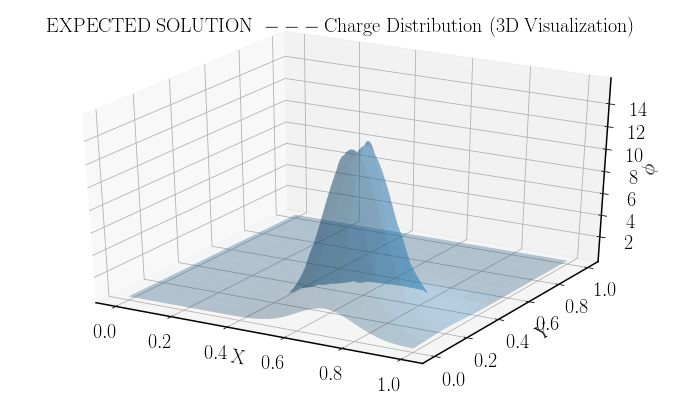

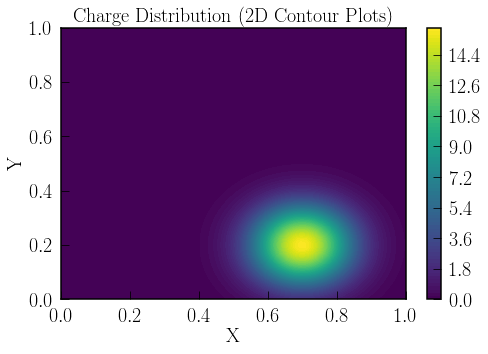

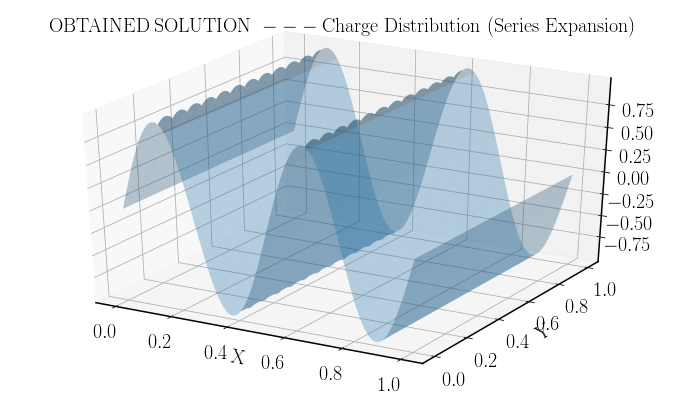

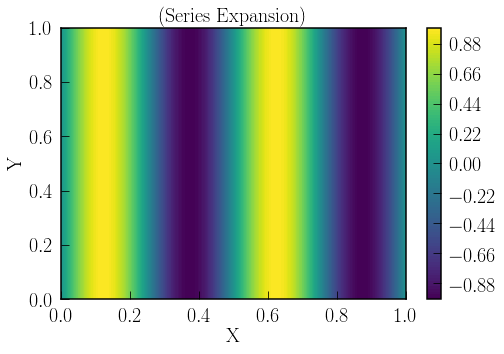

In [17]:
plot_in_3d_2d(rho,'$\mathrm{EXPECTED\;SOLUTION\;---Charge\;Distribution\;(3D\;Visualization)}$','$\mathrm{Charge\;Distribution\;(2D\;Contour\;Plots)}$','$\mathrm{\phi}$')

plot_in_3d_2d(rho_analytic,'$\mathrm{OBTAINED\;SOLUTION\;---Charge\;Distribution\;(Series\;Expansion)}$','$\mathrm{(Series\;Expansion)}$','')

In [18]:
### Calculation phi from rho's coefficients
x                   = np.linspace(epsilon,1.0,nx)
y                   = np.linspace(epsilon,1.0,ny)


phi_analytic        = np.zeros((nx,ny))

for x_coordinate in range(nx):
    for y_coordinate in range(ny):
        for i in range(N):
            for j in range(N):
                if (i==0 and j==0):
                    term_1 =  0
                    term_2 =  0
                    term_3 =  0
                    term_4 =  0

                else :
                    term_1, term_2, term_3, term_4 = getting_coefficient_terms_for_phi(i, j, x_coordinate, y_coordinate)

                phi_analytic[x_coordinate][y_coordinate] += term_1 +term_2 +term_3 +term_4



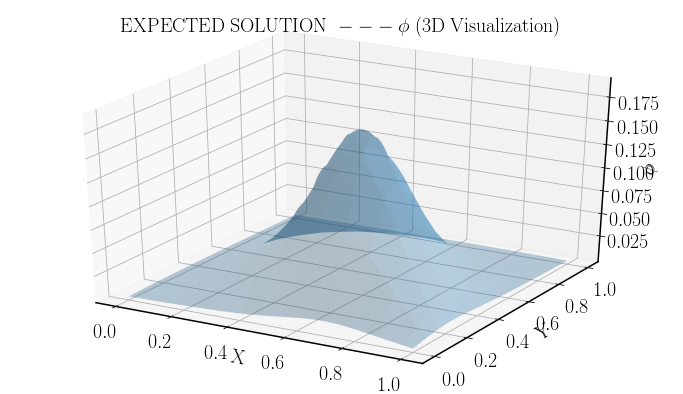

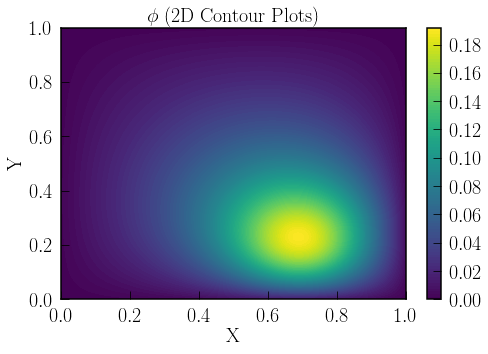

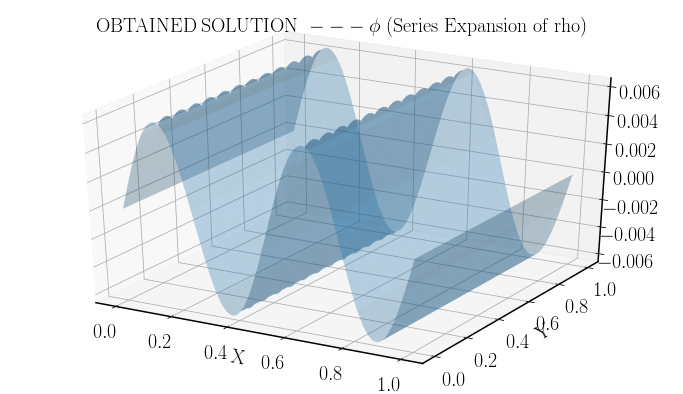

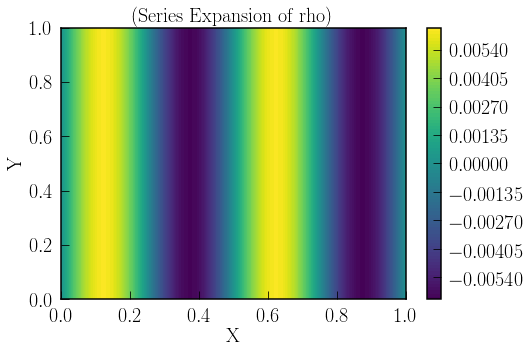

In [19]:
plot_in_3d_2d(phi,'$\mathrm{EXPECTED\;SOLUTION\;---\phi\;(3D\;Visualization)}$','$\mathrm{\phi\;(2D\;Contour\;Plots)}$','$\mathrm{\phi}$')

plot_in_3d_2d(phi_analytic,'$\mathrm{OBTAINED\;SOLUTION\;---\phi\;(Series\;Expansion\;of\;rho)}$','$\mathrm{(Series\;Expansion\;of\;rho)}$','')

In [20]:
coefficient_c_ij


array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  2.08095437e-17,   2.64819976e-18,  -9.32788787e-19,
          1.52121710e-19,   5.21542161e-19,   1.59149825e-19,
         -1.55632103e-18,  -1.43037712e-18,  -2.55289547e-18,
         -3.57205605e-18],
       [  1.00000000e+00,  -2.77555756e-17,  -2.77555756e-17,
         -2.70161697e-16,  -5.62050406e-16,  -3.63775739e-16,
         -2.05013981e-16,  -2.76769138e-16,  -6.76542156e-16,
          4.13310114e-16],
       [  3.07442041e-17,   1.06469712e-18,   9.40285924e-19,
          1.32759233e-19,   4.36008553e-19,  -1.11076564e-18,
         -4.65146015e-19,  -5.00843230e-20,  -1.15607210e-18,
          1.23891071e-18],
       [  9.14049524e-18,   1.26400457e-18,   2.56039918e-20,
          2.30297918e-19,   6.78122922e-19,   4.04562570e-19,
         -1.01052893e-18

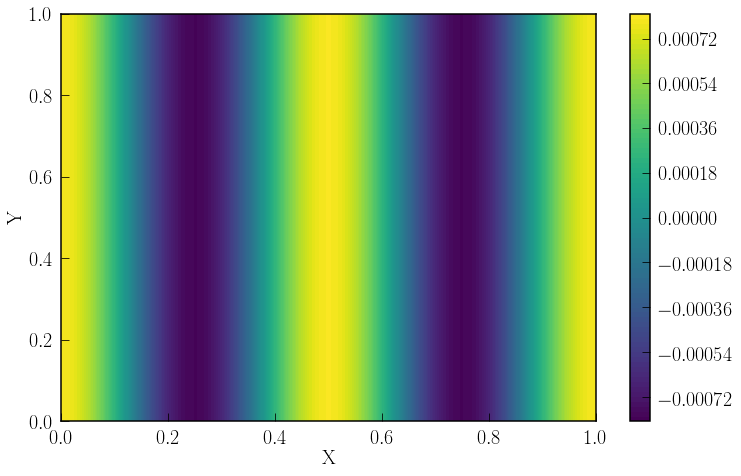

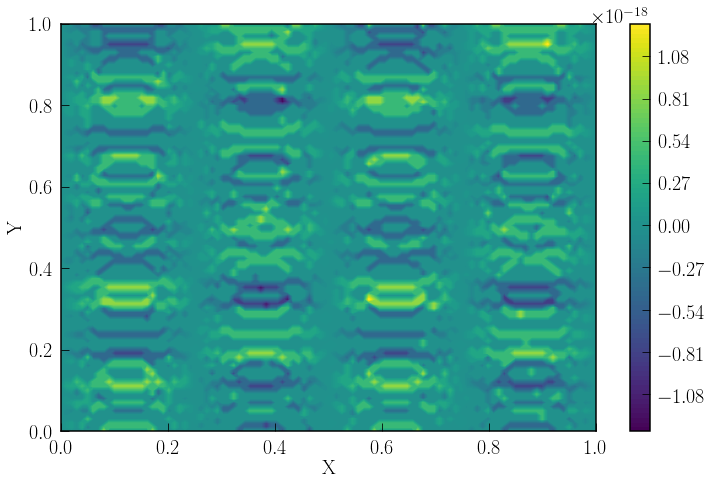

In [21]:
vgrad = np.gradient(phi_analytic)
xgrad = vgrad[0]
ygrad = vgrad[1]

E_mag = np.power(xgrad, 2) + np.power(ygrad, 2)

x, y = mgrid[0:1:(nx*1j), 0:1:(ny*1j)]
plt.xlabel('$\mathrm{X}$')
plt.ylabel('$\mathrm{Y}$')
plt.contourf(x,y, xgrad, 100)
plt.colorbar()
plt.show()

plt.xlabel('$\mathrm{X}$')
plt.ylabel('$\mathrm{Y}$')
plt.contourf(x,y, ygrad, 100)
plt.colorbar()
plt.show()

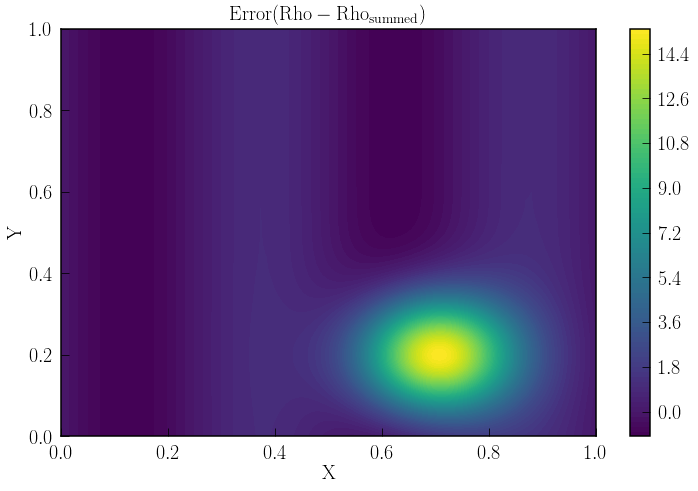

In [22]:
#### NOISE CALCULATION
# # visualize in 2d
plt.title('$\mathrm{Error(Rho - Rho_{summed})}$')
plt.xlabel('X')
plt.ylabel('Y')
x, y = mgrid[0:1:(nx*1j), 0:1:(ny*1j)]
plt.contourf(x,y,rho-rho_analytic , 100)
plt.colorbar()
plt.show()


In [24]:
print (phi_analytic[0][0])
print (phi_analytic[0][nx-1])
print (phi_analytic[nx-1][0])
print (phi_analytic[nx-1][nx-1])

-1.95292455399e-18
-1.95292455399e-18
-5.05499113483e-18
-5.05499113483e-18
